In [61]:
import numpy as np
def fedProxSat(sat_df, 
              counter, 
              client_n, 
              client_max, 
              sat_n, 
              factor_s, 
              factor_c, 
              server_round,
              clients):

    # Track starting time for reaching out to satellites
    start_time_sec = sat_df['Start Time Seconds Cumulative'].iloc[counter]

    # lists for tracking satellites
    client_list = np.zeros(client_n)
    client_time_list = np.zeros(client_n)
    client_twice = []
    done_count = 0
    idle_time_total = 0

    # Check if the number of satellites exceeds maximum 
    # we want to train with each round
    if client_n < client_max:
        limit = client_n
    else:
        limit = client_max

    # Looping through the CSV
    while done_count < limit:

        # need cluster and satellite id to calculate client_id
        cluster_id = ((sat_df['cluster_num'].iloc[counter]))
        satellite_id = ((sat_df['sat_num'].iloc[counter]))

        # calculate client_id from which cluster and which satellite
        client_id = int(sat_n*(cluster_id/factor_c)-
                        (sat_n-(satellite_id/factor_s))-1)

        # Track the first 10 satellites that make contact with a groundstation 
        if client_list[client_id] == 0 and len(client_twice) < limit:
            client_twice.append(client_id)
            client_time_list[client_id] = sat_df['Start Time Seconds Cumulative'].iloc[counter]
            # print("FIRST TIME")
            # print(counter)
            # print(client_list)
            # print(client_twice)
            # print(client_time_list)
        
        # Track every single pass of every client satellite
        client_list[client_id] += 1

        # Track when the first 10 satellites that made contact reach back to a groundstation to give their information
        if client_list[client_id] == 2 and (client_id in client_twice):
            done_count +=1
            client_time_list[client_id] = sat_df['End Time Seconds Cumulative'].iloc[counter] - client_time_list[client_id]
            # print("SECOND TIME")
            # print(counter)
            # print(client_list)
            # print(client_twice)
            # print(client_time_list)
        # Going through the csv rows
        counter += 1

    # TODO: Delete whenever i realize i know how to track this in wandb
    # for time in client_time_list:
    #     if time > 30000:
    #         print("CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK")
    #         print(client_list)
    #         print(client_twice)
    #         print(client_time_list)

    # Track when we finish reach out to all satellites
    stop_time_sec = sat_df['Start Time Seconds Cumulative'].iloc[counter]
    
    # Caculate idle time totals and averages
    for time in client_time_list:
        idle_time_total += (stop_time_sec - start_time_sec)-(10* 60 * 5) 
    idle_time_avg = idle_time_total/client_n
    y = {"start_time_sec": start_time_sec, 
            "stop_time_sec": stop_time_sec, 
            "server_round": server_round,
            "duration" : stop_time_sec - start_time_sec, 
            "idle_time_total": idle_time_total,
            "idle_time_avg": idle_time_avg}
    # wandb.log({"start_time_sec": start_time_sec, 
    #            "stop_time_sec": stop_time_sec, 
    #            "server_round": server_round,
    #            "duration" : stop_time_sec - start_time_sec, 
    #            "idle_time_total": idle_time_total,
    #            "idle_time_avg": idle_time_avg})

    # this is the only thing that differs for fedprox, now we send durations too
    # most changes are in client
    # x = [(client,client_time_list[int(client.cid)]) for client in clients if int(client.cid) in client_twice]
    x = [(client,client_time_list[client]) for client in clients if int(client) in client_twice]

    return x, counter, y


In [8]:
import numpy as np
import wandb
###################    FedProx2Sat   ########################

def fedProx2Sat(sat_df, 
              counter, 
              client_n, 
              client_max, 
              sat_n, 
              factor_s, 
              factor_c, 
              server_round,
              clients):

    # Track starting time for reaching out to satellites
    start_time_sec = sat_df['Start Time Seconds Cumulative'].iloc[counter]

    # lists for tracking satellites
    client_list = np.zeros(client_n)
    client_time_list = np.zeros(client_n)
    client_twice = []
    done_count = 0
    idle_time_total = 0

    # Check if the number of satellites exceeds maximum 
    # we want to train with each round
    if client_n < client_max:
        limit = client_n
    else:
        limit = client_max

    # Looping through the CSV
    while done_count < limit:

        # need cluster and satellite id to calculate client_id
        cluster_id = ((sat_df['cluster_num'].iloc[counter]))
        satellite_id = ((sat_df['sat_num'].iloc[counter]))

        # calculate client_id from which cluster and which satellite
        client_id = int(sat_n*(cluster_id/factor_c)-
                        (sat_n-(satellite_id/factor_s))-1)

        # Track every single pass of every client satellite
        client_list[client_id] += 1

        # just keep start time for all clients in case we want to use them
        if client_time_list[client_id] == 0:
            client_time_list[client_id] = sat_df['Start Time Seconds Cumulative'].iloc[counter]
            # print("FIRST TIME")
            # print(counter)
            # print(client_list)
            # print(client_twice)
            # print(client_time_list)
        
        # Track the first 10 satellites that make contact twice with a groundstation 
        if client_list[client_id] == 2 and len(client_twice) < limit:
            client_twice.append(client_id)
            client_time_list[client_id] = sat_df['End Time Seconds Cumulative'].iloc[counter] - client_time_list[client_id]
            done_count +=1
            # print("SECOND TIME")
            # print(counter)
            # print(client_list)
            # print(client_twice)
            # print(client_time_list)
            
        # Going through the csv rows
        counter += 1
        

    for id in range(client_n):
        # Only track satellties as having been not idle if they trained this round
        if id not in client_twice:
            client_time_list[id] = 0
    

    # TODO: Delete whenever i realize i know how to track this in wandb

    for time in client_time_list:
        if time > 30000:
            print("CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK")
            print(client_list)
            print(client_twice)
            print(client_time_list)

    # Track when we finish reach out to all satellites
    stop_time_sec = sat_df['Start Time Seconds Cumulative'].iloc[counter]
    
    # Caculate idle time totals and averages
    for time in client_time_list:
        idle_time_total += (stop_time_sec - start_time_sec)-time 
    idle_time_avg = idle_time_total/client_n
    y = {"start_time_sec": start_time_sec, 
               "stop_time_sec": stop_time_sec, 
               "server_round": server_round,
               "duration" : stop_time_sec - start_time_sec, 
               "idle_time_total": idle_time_total,
               "idle_time_avg": idle_time_avg}
    # wandb.log({"start_time_sec": start_time_sec, 
    #            "stop_time_sec": stop_time_sec, 
    #            "server_round": server_round,
    #            "duration" : stop_time_sec - start_time_sec, 
    #            "idle_time_total": idle_time_total,
    #            "idle_time_avg": idle_time_avg})

    # this is the only thing that differs for fedprox, now we send durations too
    # most changes are in client
    # x = [(client,client_time_list[int(client.cid)]) for client in clients if int(client.cid) in client_twice]
    x = [(client,client_time_list[client]) for client in clients if int(client) in client_twice]


    return x, counter, y

def choose_sat_csv(df, og_s, og_c, new_s, new_c, gs):
    if og_s%new_s == 0 and og_c%new_c == 0:
        client_list = [int(og_s/new_s*(i+1)) for i in range(new_s)]
        cluster_list = [int(og_c/new_c*(i+1)) for i in range(new_c)]
    mask = (df['cluster_num'].isin(cluster_list) & (df['sat_num'].isin(client_list)) & (df['ground_station'].isin(gs)))
    sat_new = df[mask]
    sat_new_sorted = sat_new.sort_values('Start Time Seconds Cumulative').reset_index()
    return sat_new_sorted

In [9]:
n_sat_c = 5
n_c = 2

gs_list = ["[Sioux_Falls]",
        "[Sioux_Falls,Sanya]",
        "[Sioux_Falls,Sanya,Johannesburg]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs,Fairbanks,Prince_Albert,Shadnagar]"]

config = {
        "name": "Pls",
        "round": 500,
        "epochs": 3,
        "trial": 5,
        "clients": n_sat_c*n_c,
        "client_limit": 10,
        "dataset": "FEMNIST",
        "alg": "fedProx2Sat",
        "learning_rate": 0.001,
        "momentum": 0.9,
        "wait_time" : 7,
        "sim_fname" : "/datasets/landsat/10s_10c_s_landsat.csv",
        "n_sat_in_cluster" : n_sat_c,
        "n_cluster" : n_c,
        "slrum" : "y",
        "client_cpu": 2,
        "client_gpu": 0,
        "prox_term": 2,
        "gs_locations" : gs_list[1]
    }

In [10]:
import pandas as pd
counter = 0
satellite_access_csv =  config["sim_fname"]
satellite_access_csv_name = satellite_access_csv
try:
    satellite_access_csv = pd.read_csv(satellite_access_csv_name)
except:
    satellite_access_csv = pd.read_csv(".."+satellite_access_csv_name)

# TODO: Change this it will keep causing index erros if you don't and switch the csv files
og_s = int(satellite_access_csv_name.split("/")[-1].split("_")[0][:-1])
og_c = int(satellite_access_csv_name.split("/")[-1].split("_")[1][:-1])
# config = on_fit_config_fn(1)
gs = config["gs_locations"][1:-1].split(",")
factor_s = og_s / int(config["n_sat_in_cluster"])
factor_c = og_c / int(config["n_cluster"])
# choose only satellites that we want
satellite_access_csv = choose_sat_csv(satellite_access_csv, og_s, og_c, int(config["n_sat_in_cluster"]), int(config["n_cluster"]),gs)
satellite_client_list = []

In [97]:
satellite_access_csv

,level_0,Unnamed: 0,index,Duration (sec),Start Time Seconds Cumulative,End Time Seconds Cumulative,Start Time Seconds datetime,End Time Seconds datetime,ground_station,cluster_num,sat_num
0,36,36,717817,273.431,1.711987e+09,1.711987e+09,2024-04-14 16:00:00.000,2024-04-14 16:04:33.431,Kashi,10,4
1,48,48,703846,100.412,1.711987e+09,1.711987e+09,2024-04-14 16:00:00.000,2024-04-14 16:01:40.412,Prince_Albert,10,2
2,49,49,701090,290.638,1.711987e+09,1.711987e+09,2024-04-14 16:00:00.000,2024-04-14 16:04:50.638,Fairbanks,10,2
3,69,69,720694,401.137,1.711987e+09,1.711988e+09,2024-04-14 16:02:02.786,2024-04-14 16:08:43.923,Shadnagar,10,4
4,87,87,706167,596.014,1.711987e+09,1.711988e+09,2024-04-14 16:04:59.603,2024-04-14 16:14:55.618,Tromso,10,2
...,...,...,...,...,...,...,...,...,...,...,...
35801,768883,768883,700235,93.555,1.719848e+09,1.719848e+09,2024-07-14 15:31:57.305,2024-07-14 15:33:30.860,Alice_Springs,10,2
35802,768911,768911,717435,279.596,1.719848e+09,1.719849e+09,2024-07-14 15:37:35.164,2024-07-14 15:42:14.760,Fairbanks,10,4
35803,768952,768952,722910,544.000,1.719849e+09,1.719849e+09,2024-07-14 15:43:08.312,2024-07-14 15:52:12.313,Tromso,10,4
35804,768975,768975,761718,431.945,1.719849e+09,1.719849e+09,2024-07-14 15:48:11.684,2024-07-14 15:55:23.629,Alice_Springs,10,10


In [125]:
counter = 0
durations = []
idle_time = []
idle_time_avg = []
for i in range(10):
    chosen_clients_times, counter, w = fedProxSat(satellite_access_csv, 
                                        counter,
                                        int(config["clients"]),
                                        int(config["client_limit"]),
                                        int(config["n_sat_in_cluster"]),
                                        factor_s,
                                        factor_c,
                                        i,
                                        range(100))
    durations.append(w['duration'])
    idle_time.append(w['idle_time_total'])
    idle_time_avg.append(w['idle_time_avg'])


CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK
[3. 4. 3. 3. 2. 4. 2. 4. 4. 3.]
[5, 8, 0, 3, 9, 7, 2, 1, 6, 4]
[ 4400.26600003  6243.6730001   6302.69199991  6325.69300008
 34371.73000002  6314.96600008 35201.65499997  2311.05999994
  2452.89199996  6281.70599985]
CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK
[3. 4. 3. 3. 2. 4. 2. 4. 4. 3.]
[5, 8, 0, 3, 9, 7, 2, 1, 6, 4]
[ 4400.26600003  6243.6730001   6302.69199991  6325.69300008
 34371.73000002  6314.96600008 35201.65499997  2311.05999994
  2452.89199996  6281.70599985]
CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK
[2. 2. 3. 2. 2. 2. 2. 2. 3. 2.]
[7, 3, 6, 2, 5, 1, 9, 0, 8, 4]
[29424.56699991 29421.67499995 29374.13600016 29208.13399982
 29376.11299992 28536.56399989 34376.35299993 34394.43099999
 28497.51999998 28547.06599998]
CHECK CHECK CHECK CHECK CHECK CHECK CHECK CHECK
[2. 2. 3. 2. 2. 2. 2. 2. 3. 2.]
[7, 3, 6, 2, 5, 1, 9, 0, 8, 4]
[29424.56699991 29421.67499995 29374.13600016 29208.13399982
 29376.11299992 28536.56399989 34

[20488.600699996947,
 28632.132700037957,
 4575.259199905396,
 5000.571100044251,
 4961.042300105095,
 4431.259699892998,
 6734.377499985695,
 12136.593500041961,
 5596.943400073052,
 12714.55450003147]

### Fake heatmaps

In [62]:
# Just some settings I set when running the tests that will make it easier to build the gaphs
import numpy as np
import configparser

epochs = [10] #[5,10,25,50,100]
sats = [1,2,5,10] #[1,2,5,10,25,50]
clusters = [1,2,5,10] #[1,5,25]
gs_list = ["[Sioux_Falls]",
        "[Sioux_Falls,Sanya]",
        "[Sioux_Falls,Sanya,Johannesburg]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs,Fairbanks,Prince_Albert,Shadnagar]"]

name = ["1_gs","2_gs","3_gs","5_gs","10_gs","all_gs"]
n_sat_c = 2
n_c = 25

config = {
        "name": "Pls",
        "round": 500,
        "epochs": 3,
        "trial": 5,
        "clients": n_sat_c*n_c,
        "client_limit": 10,
        "dataset": "FEMNIST",
        "alg": "fedProx2Sat",
        "learning_rate": 0.001,
        "momentum": 0.9,
        "wait_time" : 7,
        "sim_fname" : "/datasets/landsat/10s_10c_s_landsat.csv",
        "n_sat_in_cluster" : n_sat_c,
        "n_cluster" : n_c,
        "slrum" : "y",
        "client_cpu": 2,
        "client_gpu": 0,
        "prox_term": 0,
        "gs_locations" : "[Boston,]"
    }

import wandb
api = wandb.Api()

results3_proxm = {}
for name_list,pp in zip(name,range(6)):
    # try:
        data = np.zeros((4,4))
        data2 = np.zeros((4,4))
        data3 = np.zeros((4,4))
        # data4 = np.zeros((4,4))
        rows = 0
        cols = 0
        for epoch in epochs:
            for sat in sats:
                for cluster in clusters:
                    print(gs_list[pp])
                    config["gs_locations"] = gs_list[pp]
                    config["epochs"] = str(epoch)
                    config["n_sat_in_cluster"] = str(sat)
                    config["clients"] = str(sat*cluster)
                    config["n_cluster"] = str(cluster)
                    config["name"] = name_list
                    t_name = "WorkFP_5_03"  
                    for keys in config.keys():
                        if keys != "sim_fname" and keys != "gs_locations" and keys != "slrum"  and keys != "client_cpu"  and keys != "client_gpu":
                            t_name = t_name + "_"+keys[:1]+str(config[keys])
                    print(t_name)
                    if not (rows == 0 and cols == 0):
                        counter = 0
                        durations = []
                        idle_time = []
                        idle_time_avg = []
                        satellite_access_csv =  config["sim_fname"]
                        satellite_access_csv_name = satellite_access_csv
                        
                        try:
                            satellite_access_csv = pd.read_csv(satellite_access_csv_name)
                        except:
                            satellite_access_csv = pd.read_csv(".."+satellite_access_csv_name)

                        # TODO: Change this it will keep causing index erros if you don't and switch the csv files
                        og_s = int(satellite_access_csv_name.split("/")[-1].split("_")[0][:-1])
                        og_c = int(satellite_access_csv_name.split("/")[-1].split("_")[1][:-1])
                        # config = on_fit_config_fn(1)
                        gs = config["gs_locations"][1:-1].split(",")
                        factor_s = og_s / int(config["n_sat_in_cluster"])
                        factor_c = og_c / int(config["n_cluster"])
                        # choose only satellites that we want
                        satellite_access_csv = choose_sat_csv(satellite_access_csv, og_s, og_c, int(config["n_sat_in_cluster"]), int(config["n_cluster"]),gs)
                        
                        for i in range(500):
                            try:
                                chosen_clients_times, counter, w = fedProxSat(satellite_access_csv, 
                                                                    counter,
                                                                    int(config["clients"]),
                                                                    int(config["client_limit"]),
                                                                    int(config["n_sat_in_cluster"]),
                                                                    factor_s,
                                                                    factor_c,
                                                                    i,
                                                                    range(100))
                                durations.append(w['duration'])
                                idle_time.append(w['idle_time_total'])
                                idle_time_avg.append(w['idle_time_avg'])
                            except Exception as error:
                                # handle the exception
                                print("An exception occurred:", error) 
                                print(i)
                                break
                                
                        
                        print(durations)
                        print(idle_time)
                        print(idle_time_avg)
                        data[rows,cols] = np.mean(durations)
                        data2[rows,cols] = np.mean(idle_time)
                        data3[rows,cols] = np.mean(idle_time_avg)
                        # data4[rows,cols] = np.mean(a)
                    cols += 1
                cols = 0
                rows += 1
        results3_proxm[name_list+"_duration"] = data
        results3_proxm[name_list+"_idle_time_total_avg"] = data2
        results3_proxm[name_list+"_idle_time_sat_avg"] = data3
    # except Exception as error:
    #     # handle the exception
    #     print("An exception occurred:", error) 

[Sioux_Falls]
WorkFP_5_03_n1_gs_r500_e10_t5_c1_c10_dFEMNIST_afedProx2Sat_l0.001_m0.9_w7_n1_n1_p0
[Sioux_Falls]
WorkFP_5_03_n1_gs_r500_e10_t5_c2_c10_dFEMNIST_afedProx2Sat_l0.001_m0.9_w7_n1_n2_p0
An exception occurred: single positional indexer is out-of-bounds
219
[41112.60299992561, 44099.238000154495, 39973.19499993324, 39505.668999910355, 40164.38499999046, 11555.302000045776, 41034.75300002098, 44140.05399990082, 35397.71600008011, 44009.22200012207, 39590.982999801636, 11643.101999998093, 35220.2610001564, 44012.75699996948, 41263.96700000763, 44009.5039999485, 40129.06500005722, 39712.09999990463, 11209.319000005722, 39994.015000104904, 35665.05999994278, 11340.262000083923, 44160.55099987984, 41088.06699991226, 44113.50200009346, 39379.34599995613, 40073.21800017357, 39610.40599989891, 11514.897000074387, 35325.74300003052, 44010.31299996376, 41268.35299992561, 44009.298000097275, 40144.258999824524, 39760.72000002861, 11118.434000015259, 40012.549000024796, 41260.40400004387, 44

In [133]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [23]:
results3_proxm

{'1_gs_duration': array([[    0.        , 38099.21370001, 39968.2905    , 40548.9076    ],
        [34388.53940001, 38099.21370001, 40548.9076    , 40255.096     ],
        [37877.93039999, 42116.05669999, 39523.9559    , 36255.3086    ],
        [37879.6336    , 29351.0846    , 35290.6701    , 34434.55569999]]),
 '1_gs_idle_time_total_avg': array([[      0.        ,   34050.19950001,  139902.70350018,
          296234.88670011],
        [  33884.28650007,   65436.63240004,  300443.01170015,
          664283.86070004],
        [  89026.74539998,  191717.56709993,  838193.58309994,
         1643397.87149982],
        [ 178337.48510001,  418564.91229982, 1600010.13769987,
         3265270.65899923]]),
 '1_gs_idle_time_sat_avg': array([[    0.        , 17025.09975001, 27980.54070004, 29623.48867001],
        [16942.14325004, 16359.15810001, 30044.30117002, 33214.193035  ],
        [17805.34908   , 19171.75670999, 33527.743324  , 32867.95743   ],
        [17833.74851   , 20928.24561499, 32

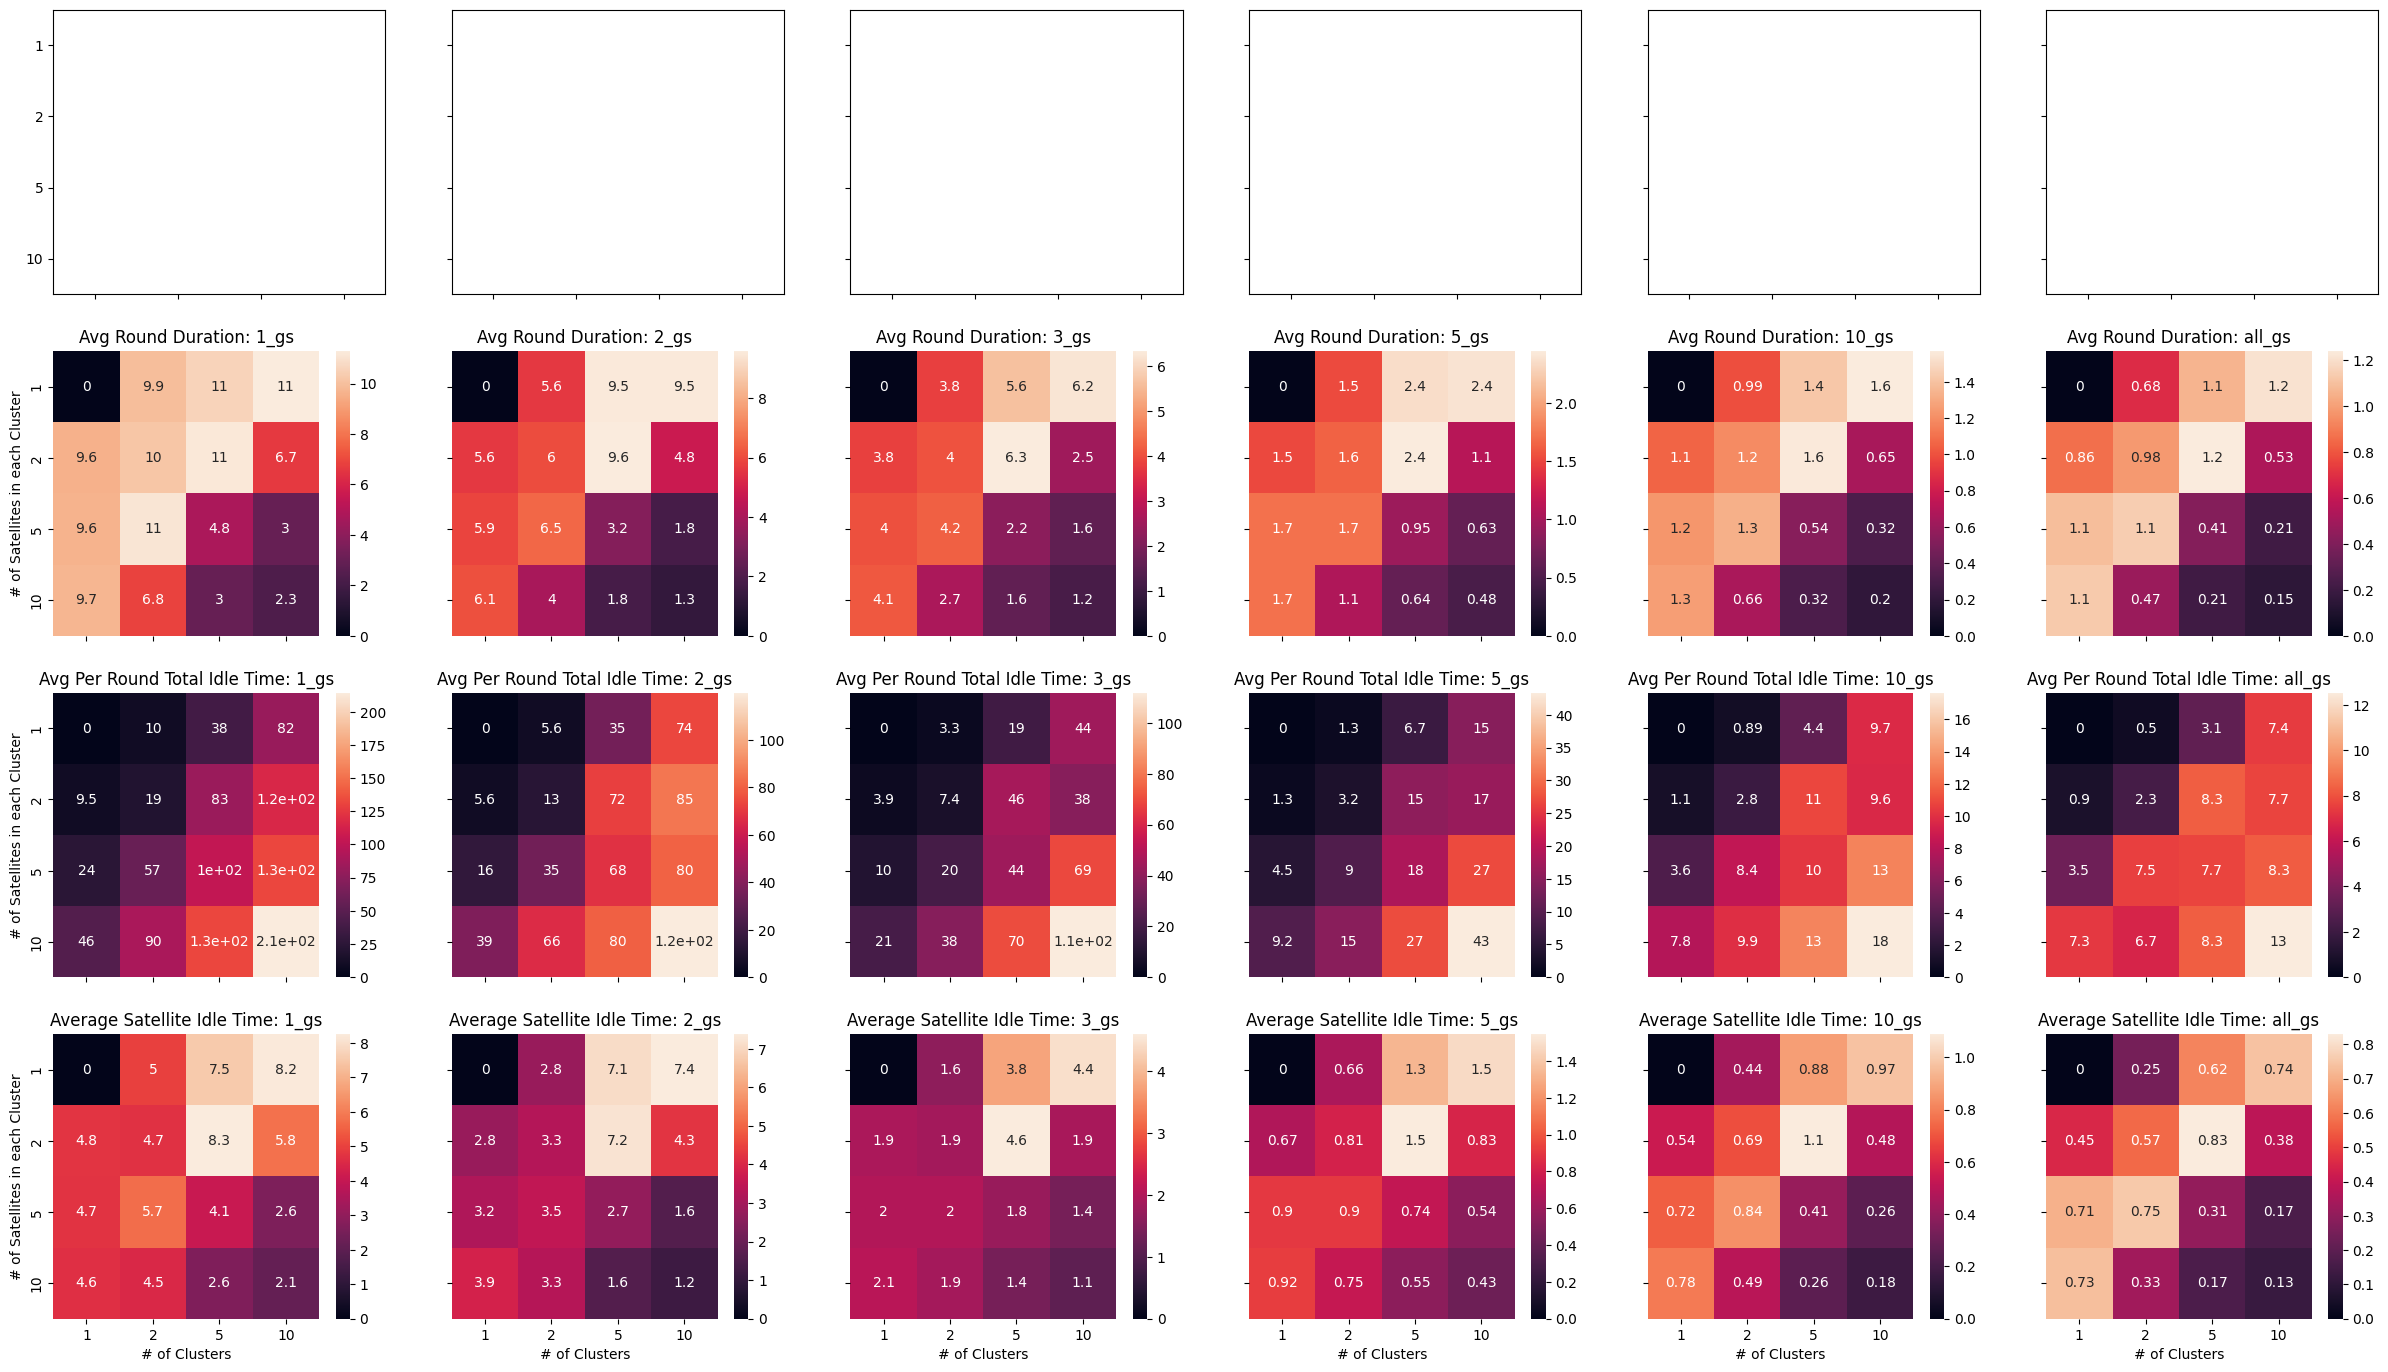

In [60]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax =  plt.subplots(4, 6, figsize=(30,17),sharex=True, sharey=True)
for i,name_list in zip(range(6),name):
    if i == 0:
        
        plt.subplot(4, 6, i+7)
        sns.heatmap(results3_proxm[name_list+"_duration"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set( ylabel='# of Satellites in each Cluster')
        plt.title("Avg Round Duration: "+ name_list)


        plt.subplot(4, 6, i+13)
        sns.heatmap(results3_proxm[name_list+"_idle_time_total_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set( ylabel='# of Satellites in each Cluster')
        plt.title("Avg Per Round Total Idle Time: "+ name_list)

        plt.subplot(4, 6, i+19)
        sns.heatmap(results3_proxm[name_list+"_idle_time_sat_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set(xlabel='# of Clusters', ylabel='# of Satellites in each Cluster')
        plt.title("Average Satellite Idle Time: "+ name_list)
    else:
        
        plt.subplot(4, 6, i+7)
        sns.heatmap(results3_proxm[name_list+"_duration"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10])
        plt.title("Avg Round Duration: "+ name_list)

        plt.subplot(4, 6, i+13)
        sns.heatmap(results3_proxm[name_list+"_idle_time_total_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10])
        plt.title("Avg Per Round Total Idle Time: "+ name_list)

        plt.subplot(4, 6, i+19)
        sns.heatmap(results3_proxm[name_list+"_idle_time_sat_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set(xlabel='# of Clusters')
        plt.title("Average Satellite Idle Time: "+ name_list)

plt.show()

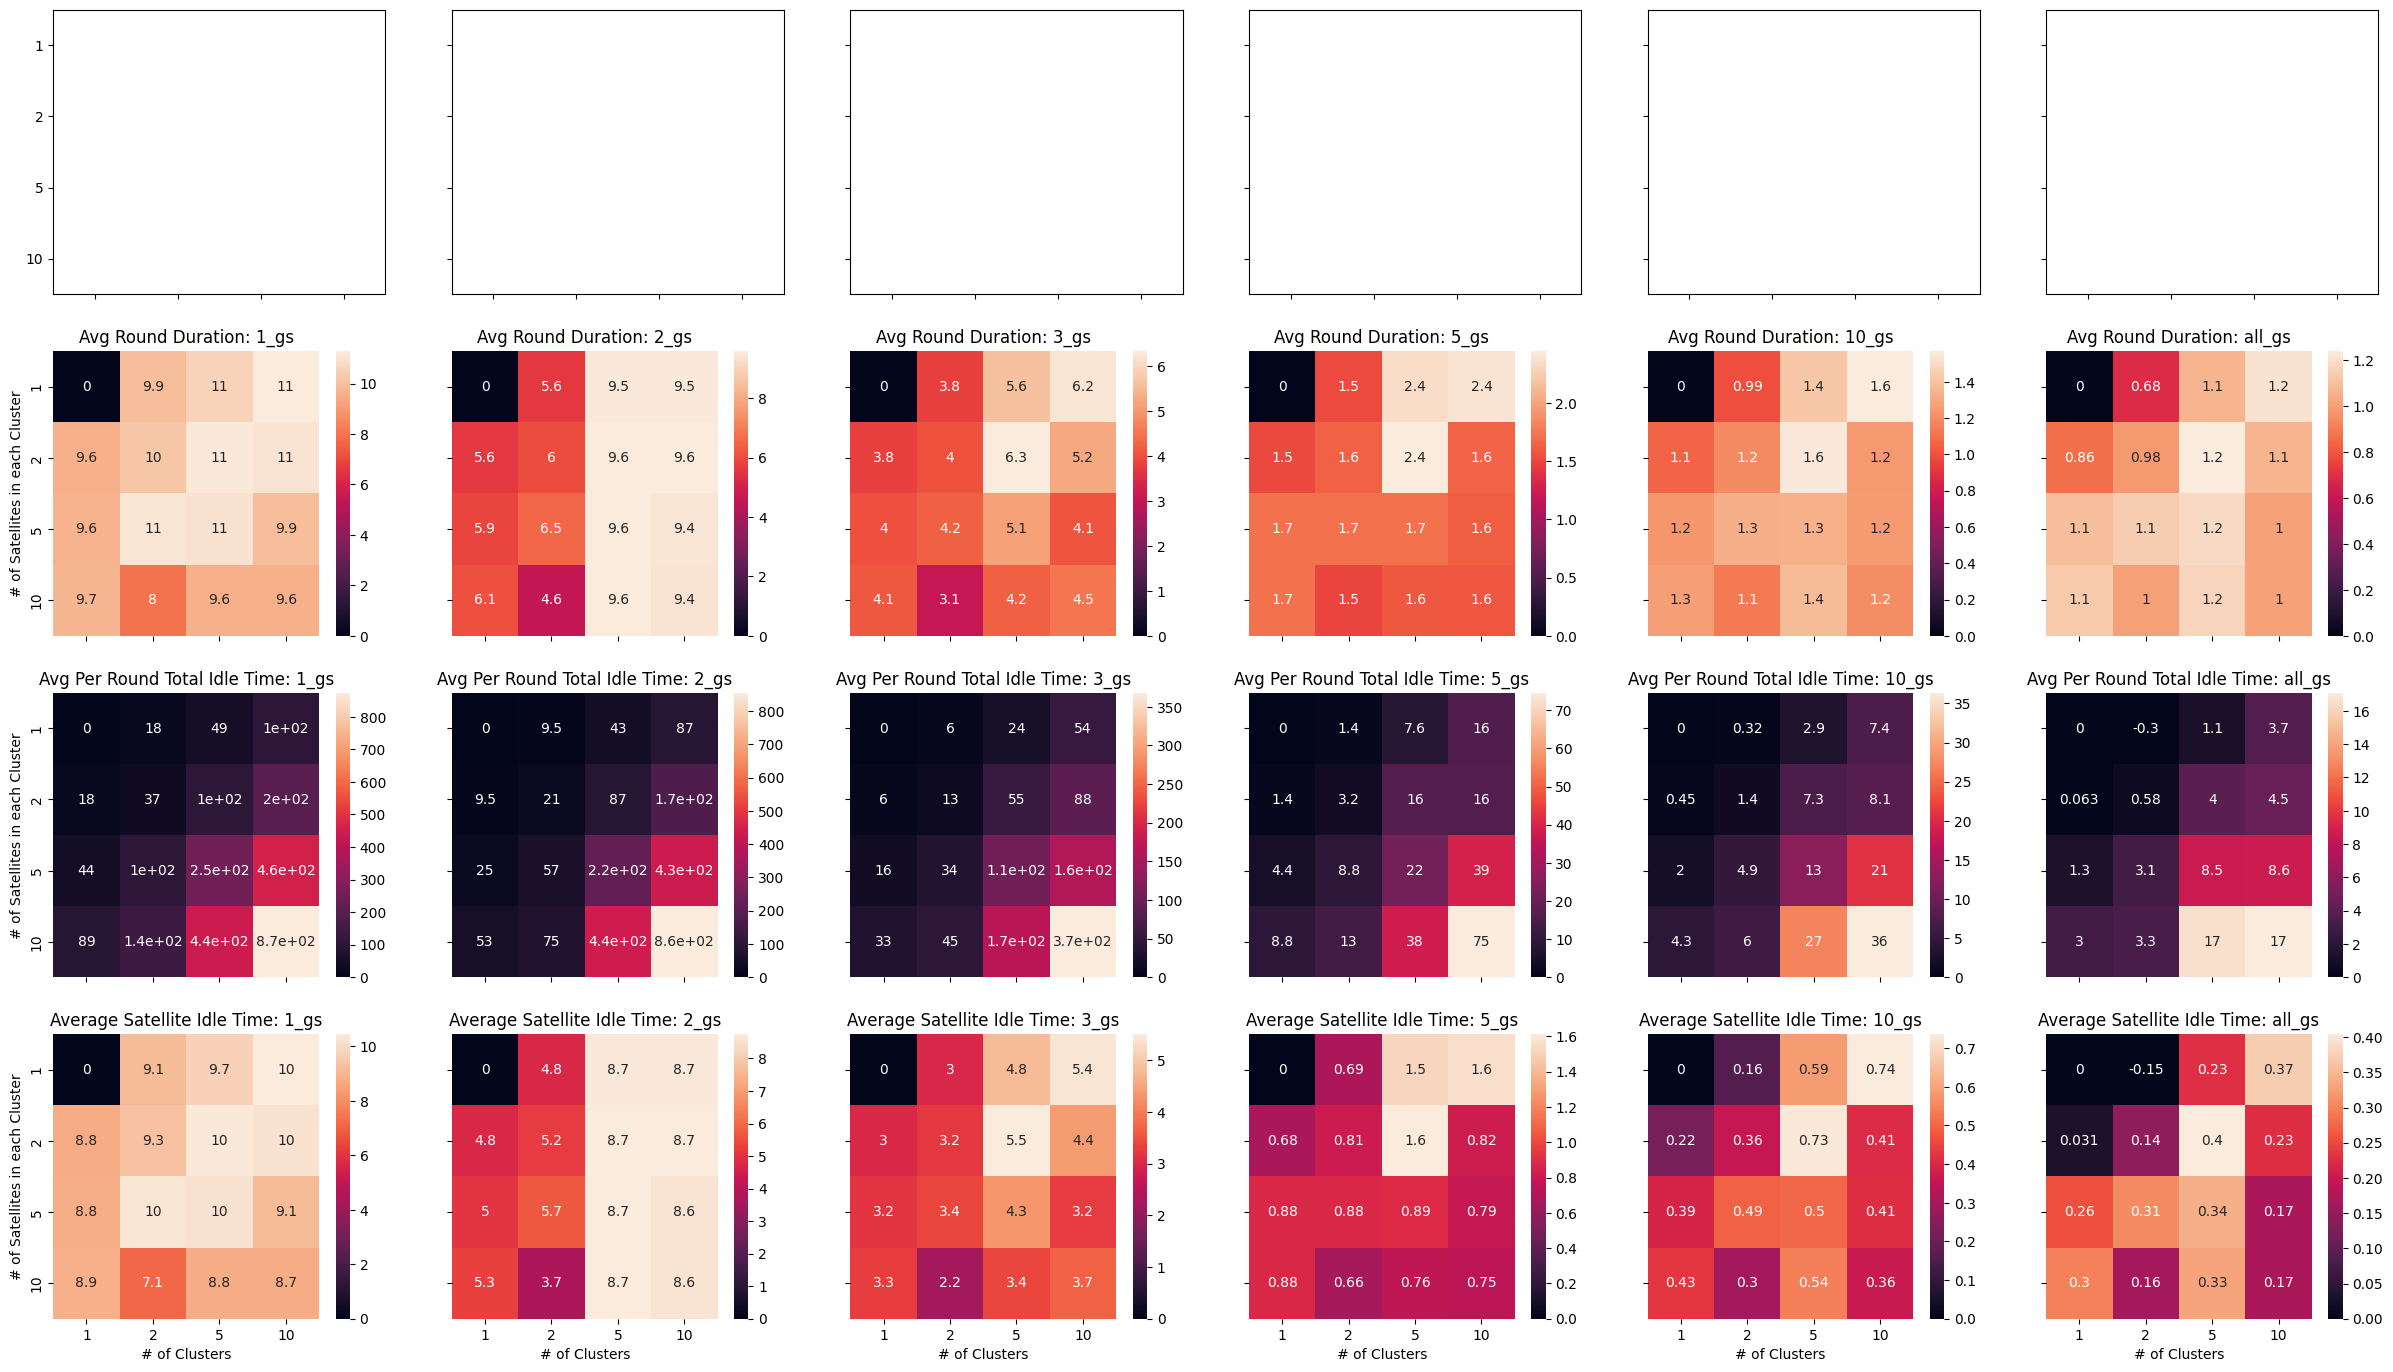

In [63]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax =  plt.subplots(4, 6, figsize=(30,17),sharex=True, sharey=True)
for i,name_list in zip(range(6),name):
    if i == 0:
        
        plt.subplot(4, 6, i+7)
        sns.heatmap(results3_proxm[name_list+"_duration"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set( ylabel='# of Satellites in each Cluster')
        plt.title("Avg Round Duration: "+ name_list)


        plt.subplot(4, 6, i+13)
        sns.heatmap(results3_proxm[name_list+"_idle_time_total_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set( ylabel='# of Satellites in each Cluster')
        plt.title("Avg Per Round Total Idle Time: "+ name_list)

        plt.subplot(4, 6, i+19)
        sns.heatmap(results3_proxm[name_list+"_idle_time_sat_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set(xlabel='# of Clusters', ylabel='# of Satellites in each Cluster')
        plt.title("Average Satellite Idle Time: "+ name_list)
    else:
        
        plt.subplot(4, 6, i+7)
        sns.heatmap(results3_proxm[name_list+"_duration"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10])
        plt.title("Avg Round Duration: "+ name_list)

        plt.subplot(4, 6, i+13)
        sns.heatmap(results3_proxm[name_list+"_idle_time_total_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10])
        plt.title("Avg Per Round Total Idle Time: "+ name_list)

        plt.subplot(4, 6, i+19)
        sns.heatmap(results3_proxm[name_list+"_idle_time_sat_avg"]/60/60,annot=True,vmin=0,xticklabels = [1,2,5,10],yticklabels = [1,2,5,10]).set(xlabel='# of Clusters')
        plt.title("Average Satellite Idle Time: "+ name_list)

plt.show()

In [38]:
n_sat_c = 5
n_c = 1

gs_list = ["[Sioux_Falls]",
        "[Sioux_Falls,Sanya]",
        "[Sioux_Falls,Sanya,Johannesburg]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs]",
        "[Sioux_Falls,Sanya,Johannesburg,Cordoba,Tromso,Kashi,Beijing,Neustrelitz,Parepare,Alice_Springs,Fairbanks,Prince_Albert,Shadnagar]"]

config = {
        "name": "Pls",
        "round": 500,
        "epochs": 3,
        "trial": 5,
        "clients": n_sat_c*n_c,
        "client_limit": 10,
        "dataset": "FEMNIST",
        "alg": "fedProx2Sat",
        "learning_rate": 0.001,
        "momentum": 0.9,
        "wait_time" : 7,
        "sim_fname" : "/datasets/landsat/10s_10c_s_landsat.csv",
        "n_sat_in_cluster" : n_sat_c,
        "n_cluster" : n_c,
        "slrum" : "y",
        "client_cpu": 2,
        "client_gpu": 0,
        "prox_term": 2,
        "gs_locations" : gs_list[1]
    }


import pandas as pd
results = {}
for p in [1,2,5,10]:
    for q in [1,2,5,10]:
        config["clients"] = p*q
        config["n_sat_in_cluster"] = p
        config["n_cluster"] = q
        counter = 0
        satellite_access_csv =  config["sim_fname"]
        satellite_access_csv_name = satellite_access_csv
        try:
            satellite_access_csv = pd.read_csv(satellite_access_csv_name)
        except:
            satellite_access_csv = pd.read_csv(".."+satellite_access_csv_name)

        # TODO: Change this it will keep causing index erros if you don't and switch the csv files
        og_s = int(satellite_access_csv_name.split("/")[-1].split("_")[0][:-1])
        og_c = int(satellite_access_csv_name.split("/")[-1].split("_")[1][:-1])
        # config = on_fit_config_fn(1)
        gs = config["gs_locations"][1:-1].split(",")
        factor_s = og_s / int(config["n_sat_in_cluster"])
        factor_c = og_c / int(config["n_cluster"])
        # choose only satellites that we want
        satellite_access_csv = choose_sat_csv(satellite_access_csv, og_s, og_c, int(config["n_sat_in_cluster"]), int(config["n_cluster"]),gs)
        satellite_client_list = []

        counter = 0
        durations = []
        idle_time = []
        idle_time_avg = []

        for i in range(500):
            try:
                chosen_clients_times, counter, w = fedProxSat(satellite_access_csv, 
                                                    counter,
                                                    int(config["clients"]),
                                                    int(config["client_limit"]),
                                                    int(config["n_sat_in_cluster"]),
                                                    factor_s,
                                                    factor_c,
                                                    i,
                                                    range(100))
                durations.append(w['duration'])
                idle_time.append(w['idle_time_total'])
                idle_time_avg.append(w['idle_time_avg'])
            except Exception as error:
                # handle the exception
                print("An exception occurred:", error) 
                print(i)
                break


        results[str(config["n_sat_in_cluster"])+ str(config["n_cluster"])+"_duration"] = durations

An exception occurred: single positional indexer is out-of-bounds
420
An exception occurred: single positional indexer is out-of-bounds
389
An exception occurred: single positional indexer is out-of-bounds
229
An exception occurred: single positional indexer is out-of-bounds
228
An exception occurred: single positional indexer is out-of-bounds
388
An exception occurred: single positional indexer is out-of-bounds
363
An exception occurred: single positional indexer is out-of-bounds
227
An exception occurred: single positional indexer is out-of-bounds
227
An exception occurred: single positional indexer is out-of-bounds
371
An exception occurred: single positional indexer is out-of-bounds
334
An exception occurred: single positional indexer is out-of-bounds
228
An exception occurred: single positional indexer is out-of-bounds
232
An exception occurred: single positional indexer is out-of-bounds
358
An exception occurred: single positional indexer is out-of-bounds
476
An exception occurre

In [41]:
results["1"+ "1"+"_duration"]

[29892.34100008011,
 5506.276999950409,
 34592.45799994469,
 5612.536000013351,
 9608.229000091553,
 33612.0529999733,
 7547.43700003624,
 32914.37599992752,
 5404.99799990654,
 33864.64700007439,
 7409.648000001907,
 34759.16400003433,
 9256.355000019073,
 33960.68799996376,
 7313.756000041962,
 11510.575999975204,
 32512.180999994278,
 5655.871999979019,
 35617.94400000572,
 5621.257999897003,
 34528.03999996185,
 5753.7590000629425,
 9771.628999948502,
 29632.142000198364,
 5588.118999958038,
 34548.90100002289,
 5692.542999982834,
 9669.791999816895,
 29827.84700012207,
 5537.641000032425,
 34578.05399990082,
 5635.528000116348,
 9622.835999965668,
 33600.141999959946,
 7543.259999990463,
 32870.84899997711,
 5439.087000131607,
 33840.97299981117,
 7432.75400018692,
 34697.59299993515,
 5479.588000059128,
 9556.513999938965,
 33657.05599999428,
 7553.349999904633,
 38363.575000047684,
 5673.519000053406,
 35600.49799990654,
 5631.805999994278,
 34521.643000125885,
 5781.43400001525

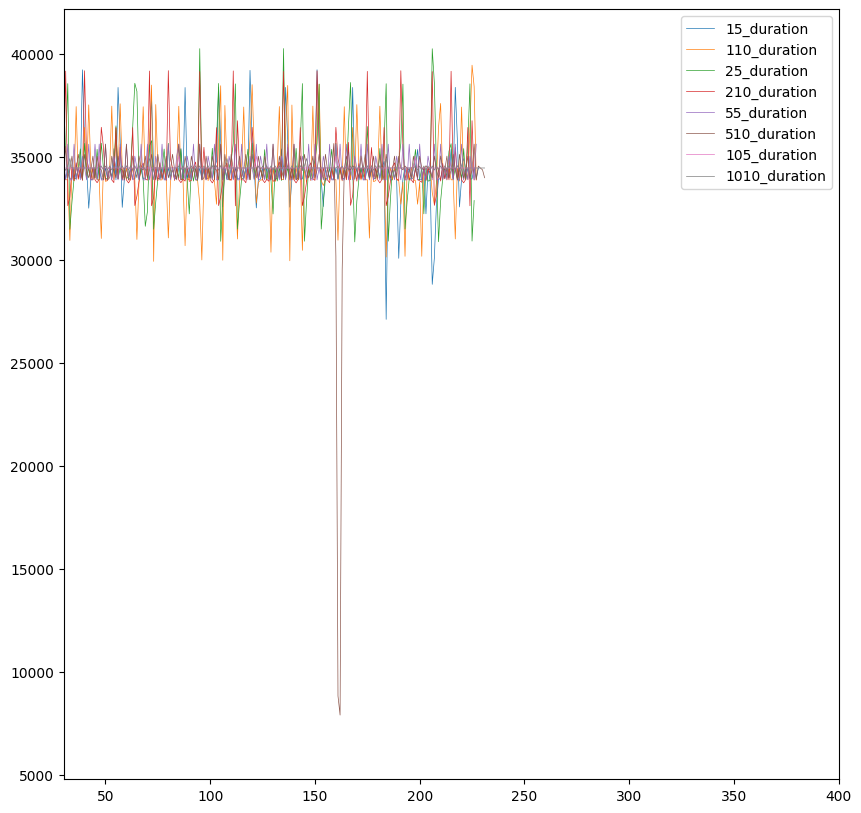

In [56]:
plt.figure(figsize=(10,10))
for l in [1,2,5,10]:
    for m in [5,10]:
        plt.plot(range(len(results[str(l)+ str(m)+"_duration"])),results[str(l)+ str(m)+"_duration"], label = str(l)+ str(m)+"_duration", linewidth = 0.5)

plt.xlim(30,400)
plt.legend()